In [ ]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import seaborn as sn
import datetime
import tensorflow as tf
from tensorflow.keras import optimizers, losses, activations, models
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Flatten, Dense, Conv1D, MaxPool1D, Dropout, LSTM
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay


In [2]:
# Focal Loss
def sparse_categorical_focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        y_true = tf.squeeze(tf.cast(y_true, tf.int32), axis=-1)
        y_true_one_hot = tf.one_hot(y_true, depth=tf.shape(y_pred)[-1])
        cross_entropy = tf.keras.losses.categorical_crossentropy(y_true_one_hot, y_pred)
        probs = tf.reduce_sum(y_true_one_hot * y_pred, axis=-1)
        focal_weight = tf.pow(1.0 - probs, gamma)
        focal_loss = alpha * focal_weight * cross_entropy
        return focal_loss
    return loss

# Class weights computation
def compute_smart_class_weights(y_train, boost_factor=2.0, abnormal_boost=3.0):
    raw_class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                           classes=np.unique(y_train),
                                                           y=y_train)
    class_weight_dict = dict(enumerate(raw_class_weights))
    majority_class = min(class_weight_dict, key=class_weight_dict.get)
    majority_weight = class_weight_dict[majority_class]
    for cls, weight in class_weight_dict.items():
        if cls != majority_class:
            class_weight_dict[cls] = max(weight, boost_factor * majority_weight)
    abnormal_classes = [1, 2, 3]
    for cls in abnormal_classes:
        if cls in class_weight_dict:
            class_weight_dict[cls] *= abnormal_boost
    print("Smart computed and boosted class weights:", class_weight_dict)
    return class_weight_dict


In [ ]:
# Load MIT-BIH dataset
df_train = pd.read_csv("data\mitbih_train.csv", header=None)
df_test = pd.read_csv("data\mitbih_test.csv", header=None)
df_combine = pd.concat([df_train, df_test])

X = df_combine.iloc[:, :-1].values
y = df_combine.iloc[:, -1].astype(int).values

X = np.expand_dims(X, axis=-1)

# Train/Val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

# Build model
model = models.Sequential([
    Conv1D(32, 5, padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001), input_shape=(187, 1)),
    Conv1D(64, 5, padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001)),
    Conv1D(64, 5, padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001)),
    Conv1D(128, 5, padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001)),
    Conv1D(128, 5, padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001)),
    MaxPool1D(pool_size=5, strides=2, padding='same'),
    Dropout(0.45),
    LSTM(210, return_sequences=True),
    MaxPool1D(pool_size=5, strides=2, padding='same'),
    Flatten(),
    Dense(5, activation='relu'),
    Dense(5, activation='softmax')
])

opt = optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=opt, loss=sparse_categorical_focal_loss(alpha=0.25, gamma=2.0), metrics=['accuracy'])
model.summary()

# Training
es_cb = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6)

class_weights = compute_smart_class_weights(y_train)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=100, batch_size=128, callbacks=[es_cb, lr_reduce],
                    class_weight=class_weights)

# Save the trained model
model.save("best_mitbih_model.h5")


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 187, 32)           192       
                                                                 
 conv1d_6 (Conv1D)           (None, 187, 64)           10304     
                                                                 
 conv1d_7 (Conv1D)           (None, 187, 64)           20544     
                                                                 
 conv1d_8 (Conv1D)           (None, 187, 128)          41088     
                                                                 
 conv1d_9 (Conv1D)           (None, 187, 128)          82048     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 94, 128)          0         
 1D)                                                             
                                                      

In [ ]:
# Save training history (history object)
import pickle

with open("best_mitbih_model.pkl", "wb") as f:
    pickle.dump(history.history, f)

In [17]:
model_mitbih = load_model("best_mitbih_model.h5", custom_objects={'loss': sparse_categorical_focal_loss(alpha=0.25, gamma=2.0)})

685/685 [==============================] - 9s 14ms/step


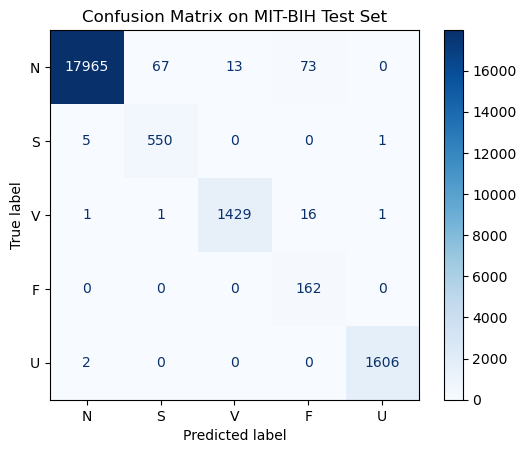

In [ ]:
# Step 1: Predict
y_pred_probs = model_mitbih.predict(np.expand_dims(df_test.iloc[:, :-1].values, axis=-1))  # shape: (num_samples, num_classes)
y_pred = np.argmax(y_pred_probs, axis=1)

# Step 2: Confusion matrix
cm = confusion_matrix(df_test.iloc[:,-1], y_pred)

# Step 3: Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['N','S','V','F','U'])  # MIT-BIH 5 classes
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix on MIT-BIH Test Set")
plt.show()


In [26]:
# Generate full classification report
print(classification_report(df_test.iloc[:,-1], y_pred, target_names=["N", "S", "V", "F", "U"]))


              precision    recall  f1-score   support

           N       1.00      0.99      1.00     18118
           S       0.89      0.99      0.94       556
           V       0.99      0.99      0.99      1448
           F       0.65      1.00      0.78       162
           U       1.00      1.00      1.00      1608

    accuracy                           0.99     21892
   macro avg       0.90      0.99      0.94     21892
weighted avg       0.99      0.99      0.99     21892



In [ ]:
# Load PTBDB
ptb_normal = pd.read_csv("data\ptbdb_normal.csv", header=None)
ptb_abnormal = pd.read_csv("data\ptbdb_abnormal.csv", header=None)

ptb_data = pd.concat([ptb_normal, ptb_abnormal])
ptb_data = ptb_data.sample(frac=1, random_state=42).reset_index(drop=True)

X_ptb = ptb_data.iloc[:, :-1].values
y_ptb = ptb_data.iloc[:, -1].values
X_ptb = np.expand_dims(X_ptb, axis=-1)

# Load the pretrained model
model = load_model("best_mitbih_model.h5", custom_objects={'loss': sparse_categorical_focal_loss(alpha=0.25, gamma=2.0)})

# Freeze early layers
for layer in model.layers[:10]:
    layer.trainable = False

# Compile with low learning rate
opt = optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss=sparse_categorical_focal_loss(alpha=0.25, gamma=2.0), metrics=['accuracy'])

# Fine-tune
es_cb = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history_ptb = model.fit(X_ptb, y_ptb, validation_split=0.2, epochs=50, batch_size=128, callbacks=[es_cb, lr_reduce])

# Save fine-tuned model
model.save("fine_tuned_ptbdb_model.h5")


Epoch 1/50
91/91 [==============================] - 5s 31ms/step - loss: 0.4968 - accuracy: 0.3808 - val_loss: 0.2621 - val_accuracy: 0.4954 - lr: 1.0000e-04
Epoch 2/50
91/91 [==============================] - 2s 17ms/step - loss: 0.1785 - accuracy: 0.6066 - val_loss: 0.1360 - val_accuracy: 0.6664 - lr: 1.0000e-04
Epoch 3/50
91/91 [==============================] - 2s 17ms/step - loss: 0.1099 - accuracy: 0.7048 - val_loss: 0.0952 - val_accuracy: 0.7375 - lr: 1.0000e-04
Epoch 4/50
91/91 [==============================] - 2s 17ms/step - loss: 0.0821 - accuracy: 0.7537 - val_loss: 0.0753 - val_accuracy: 0.7743 - lr: 1.0000e-04
Epoch 5/50
91/91 [==============================] - 2s 17ms/step - loss: 0.0653 - accuracy: 0.7853 - val_loss: 0.0624 - val_accuracy: 0.7953 - lr: 1.0000e-04
Epoch 6/50
91/91 [==============================] - 2s 17ms/step - loss: 0.0560 - accuracy: 0.8034 - val_loss: 0.0532 - val_accuracy: 0.8090 - lr: 1.0000e-04
Epoch 7/50
91/91 [==============================] - 

In [ ]:
# Save training history (history object)

with open("fine_tuned_model_history.pkl", "wb") as f:
    pickle.dump(history.history, f)

In [28]:
from tensorflow.keras.models import load_model
model_ptbdb = load_model("fine_tuned_ptbdb_model.h5", custom_objects={'loss': sparse_categorical_focal_loss(alpha=0.25, gamma=2.0)})

455/455 [==============================] - 6s 12ms/step


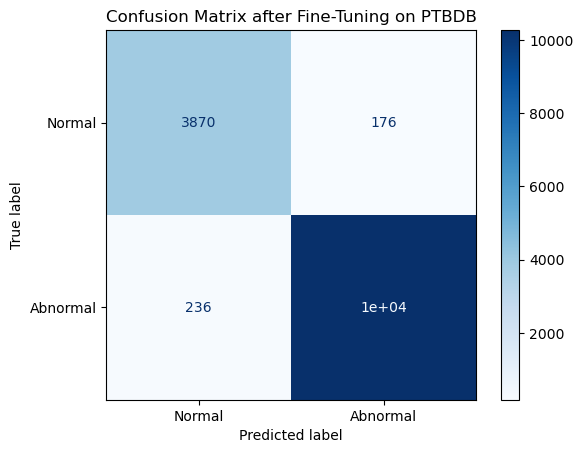

In [ ]:
# Evaluation
y_pred_probs = model_ptbdb.predict(X_ptb)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_ptb, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Abnormal'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix after Fine-Tuning on PTBDB')
plt.show()


In [30]:
print(classification_report(y_ptb, np.argmax(model_ptbdb.predict(X_ptb), axis=1), target_names=["Normal", "Abnormal"]))


455/455 [==============================] - 8s 18ms/step
              precision    recall  f1-score   support

      Normal       0.94      0.96      0.95      4046
    Abnormal       0.98      0.98      0.98     10506

    accuracy                           0.97     14552
   macro avg       0.96      0.97      0.96     14552
weighted avg       0.97      0.97      0.97     14552



In [8]:
def plot_training_history(history_dict):
    # Plot loss
    plt.figure(figsize=(10,4))
    plt.plot(history_dict['loss'], label='Training Loss')
    if 'val_loss' in history_dict:
        plt.plot(history_dict['val_loss'], label='Validation Loss')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot accuracy
    if 'accuracy' in history_dict:
        plt.figure(figsize=(10,4))
        plt.plot(history_dict['accuracy'], label='Training Accuracy')
        if 'val_accuracy' in history_dict:
            plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy vs Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
        plt.show()

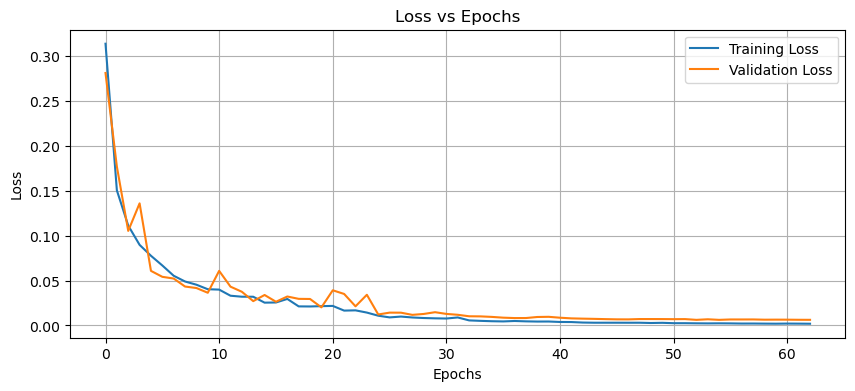

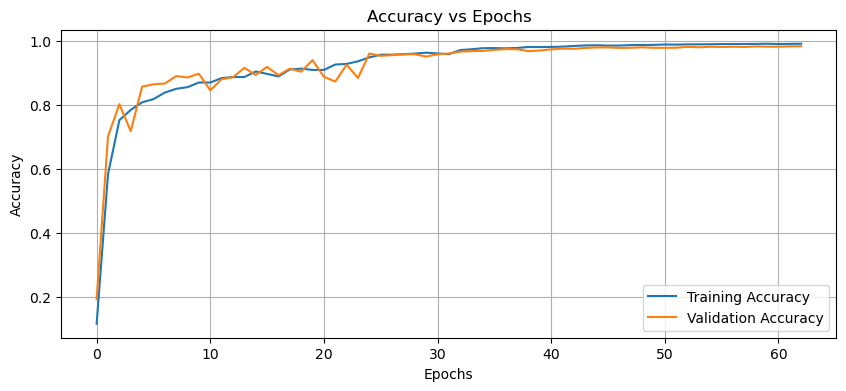

In [9]:
plot_training_history(history.history)

3421/3421 [==============================] - 41s 12ms/step


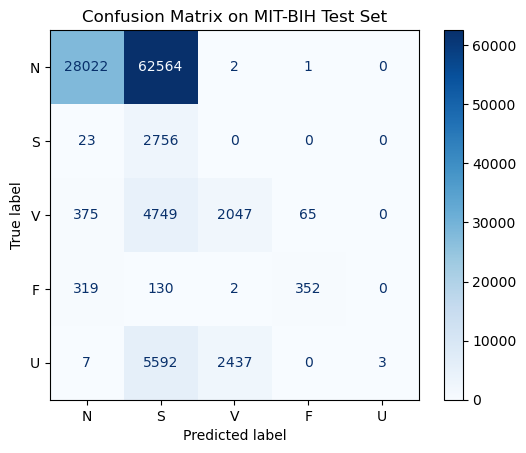

In [16]:
# Step 1: Predict
y_pred_probs = model.predict(X)  # shape: (num_samples, num_classes)
y_pred = np.argmax(y_pred_probs, axis=1)

# Step 2: Confusion matrix
cm = confusion_matrix(y, y_pred)

# Step 3: Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['N','S','V','F','U'])  # MIT-BIH 5 classes
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix on MIT-BIH Test Set")
plt.show()